# Introduction: This is a two-view DCCA test.

In [1]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

import sys
import os

sys.path.append(os.path.abspath('../'))
from tool import *

from sklearn.model_selection import train_test_split


data_root = '../../MyData/'

## Load data

In [3]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [4]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Obtain tensors

In [7]:
def convert_to_array(data_df, info_list, target_list, feature_num, ignore_nan):
    '''
    data_df     (dataframe): Entire dataset;
    info_list   (string list): Columns that don't need to be processed like 'cik', 'Year';
    target_list (strign list): The columns that needed to extract;
    feature_num (integer): Length of each datapoint;
    '''
    
    data_df = data_df[info_list + target_list]
    if ignore_nan:
        data_df = data_df.dropna(how='any')

    for target in target_list:
        data_df[target] = data_df[target].apply(
            lambda x: np.array(json.loads(x)) if pd.notna(x) else np.full(feature_num, np.nan)
            )
    
    return data_df

In [8]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']

exp_df = convert_to_array(total_embedding, info_list, target_list, 1536, True)
print(type(exp_df))
print(exp_df.shape)


item1_np = np.vstack(exp_df['item1_embeddings'].values)
sp_long_np = np.vstack(exp_df['SP_LONG_DESC_embeddings'].values)


# orbis = np.vstack(res['ORBIS_OVERVIEW_embeddings'].values)
# combined_array = np.concatenate([item1, sp_long, orbis], axis=1)

<class 'pandas.core.frame.DataFrame'>
(926, 6)


In [9]:
from sklearn.decomposition import PCA
'''
If the dimension is too large (more than 128), the deep neural network get too complex,
So it leads to severe overfitting.
'''
pca = PCA(n_components=64)
item1_np = pca.fit_transform(item1_np)
sp_long_np = pca.fit_transform(sp_long_np)

print(item1_np.shape)
item1_np

(926, 64)


array([[-0.00913671,  0.33057058, -0.08595408, ..., -0.03992022,
        -0.06222651,  0.02552353],
       [-0.18024387,  0.23354474, -0.0066326 , ...,  0.04537213,
         0.01046154, -0.05465136],
       [ 0.08223159, -0.11439043,  0.22086727, ...,  0.04843668,
        -0.02392138, -0.01543615],
       ...,
       [-0.13244995,  0.1267212 , -0.06033578, ...,  0.01546628,
        -0.09235275,  0.00525061],
       [ 0.09807554, -0.08446089,  0.08403672, ...,  0.04065317,
         0.06733916,  0.0569464 ],
       [ 0.1400567 ,  0.00146885,  0.09743251, ..., -0.03441455,
         0.03421774,  0.0554634 ]])

In [10]:
train_idx, temp_idx = train_test_split(np.arange(len(item1_np)), test_size=0.1, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split data using the computed indices
item1_train, item1_val, item1_test = item1_np[train_idx], item1_np[val_idx], item1_np[test_idx]
sp_long_train, sp_long_val, sp_long_test = sp_long_np[train_idx], sp_long_np[val_idx], sp_long_np[test_idx]

# Convert each split into torch.Tensor
train_tensor1, val_tensor1, test_tensor1 = map(lambda x: torch.tensor(x), [item1_train, item1_val, item1_test])
train_tensor2, val_tensor2, test_tensor2 = map(lambda x: torch.tensor(x), [sp_long_train, sp_long_val, sp_long_test])

item1_dataset = [train_tensor1, val_tensor1, test_tensor1]
sp_long_dataset = [train_tensor2, val_tensor2, test_tensor2]


In [16]:
item1_dataset[0].shape

torch.Size([833, 64])


# Deep CCA (DCCA) Tutorial

Deep CCA is an extension of Canonical Correlation Analysis which uses 2
Deep Neural Networks to transform each view into a lower dimensional space
which is highly correlated with the other. This can be used to uncover
latent nonlinear relations between views and is often used for feature
learning.

This tutorial uses a synthetic multiview dataset which contains
latent information shared between the views, and DCCA is used to uncover
this information in a low dimensional embedding.


In [13]:
# License: MIT

import numpy as np
from mvlearn.embed import DCCA
from mvlearn.datasets import make_gaussian_mixture
from mvlearn.plotting import crossviews_plot
from mvlearn.model_selection import train_test_split

In [14]:
# Define parameters and layers for deep model
features1 = item1_dataset[0].shape[1]  # Feature sizes
features2 = sp_long_dataset[0].shape[1]
layers1 = [128, 128, 24]  # nodes in each hidden layer and the output size
layers2 = [128, 128, 24]

dcca = DCCA(input_size1=features1, input_size2=features2, n_components=24,
            layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=500, device='cuda')
dcca.fit([item1_dataset[0], sp_long_dataset[0]])


# dcca.transform([item1_dataset[2], sp_long_dataset[2]])
Xs_transformed = dcca.transform([item1_dataset[2], sp_long_dataset[2]])

d:\Program_Files\Anaconda3\envs\NLP\lib\site-packages\mvlearn\embed\dcca.py:690: Warning: Loss did not converge before 500 epochs. Consider increasing epoch_num to train for longer.
  warnings.warn(message, Warning)


In [17]:
Xs_transformed[0].shape

(47, 24)

In [20]:
# Compute correlation for each row
def row_correlation(x, y):
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)
    
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = (x_centered * y_centered).sum(dim=1)
    denominator = torch.sqrt((x_centered ** 2).sum(dim=1) * (y_centered ** 2).sum(dim=1))
    
    correlation = numerator / denominator
    return correlation

i = 2
Xs_transformed = dcca.transform([item1_dataset[i], sp_long_dataset[i]])
correlations = row_correlation(torch.tensor(Xs_transformed[0]), torch.tensor(Xs_transformed[1]))

# Compute the average correlation
average_correlation = correlations.mean()

print("Average correlation:", average_correlation.item())

Average correlation: 0.9213117679350838


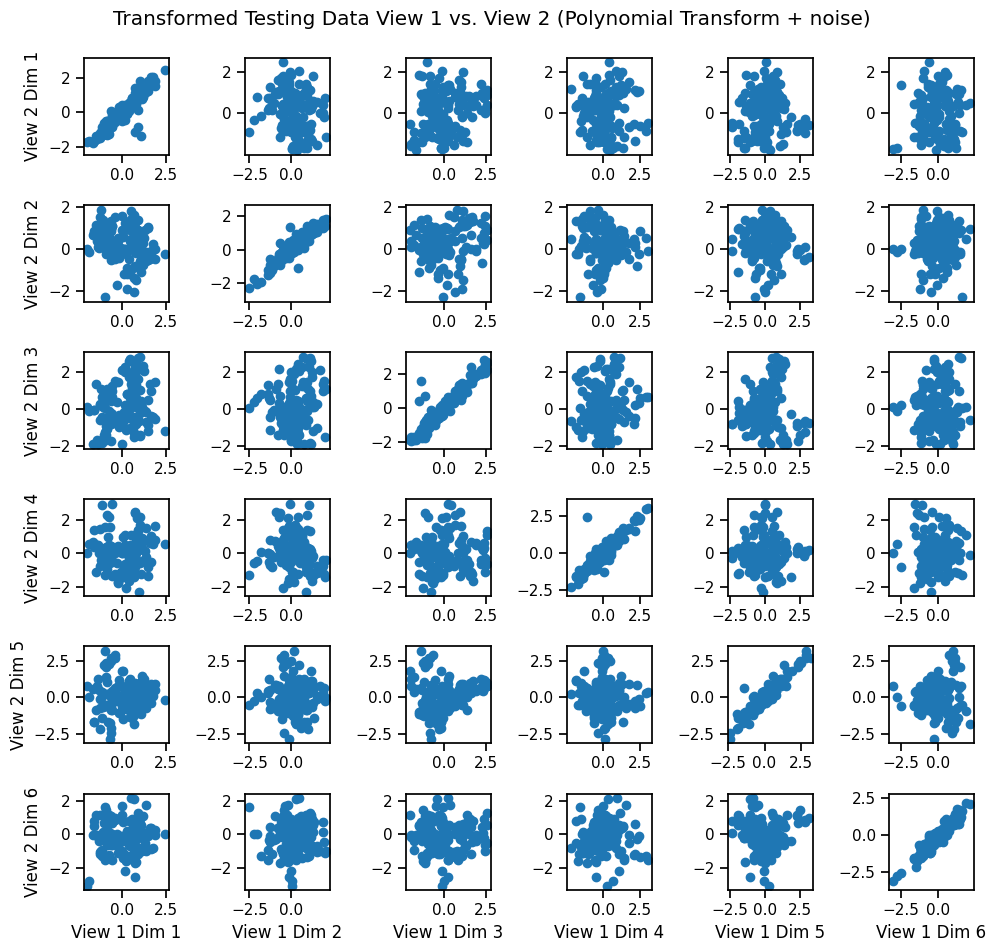

In [100]:
Xs_transformed = dcca.transform([item1_dataset[2], sp_long_dataset[2]])
crossviews_plot(Xs_transformed,
                title='Transformed Testing Data View 1 vs. View 2 '
                      '(Polynomial Transform + noise)',
                equal_axes=True)

## Polynomial-Transformed Latent Correlation

Latent variables are sampled from two multivariate Gaussians with equal
prior probability. Then a polynomial transformation is applied and noise is
added independently to both the transformed and untransformed latents.



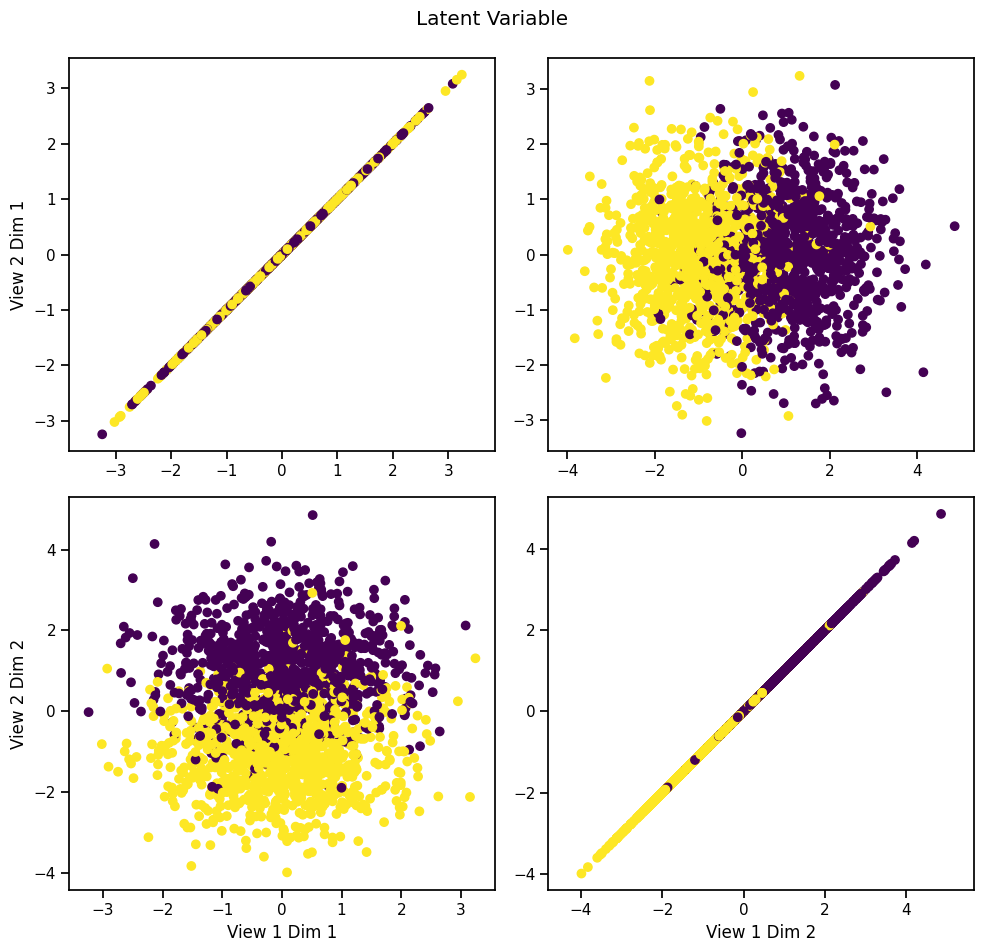

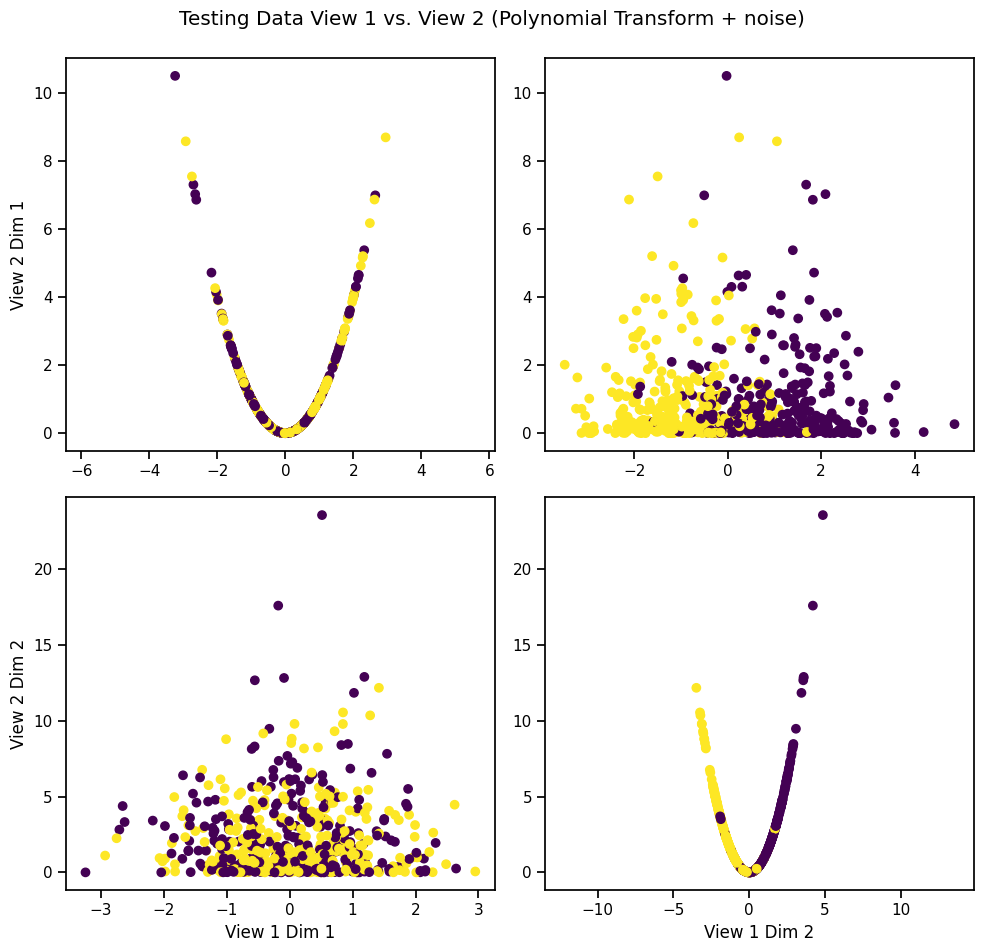

In [46]:
n_samples = 2000
means = [[0, 1], [0, -1]]
covariances = [np.eye(2), np.eye(2)]
Xs, y, latent = make_gaussian_mixture(
      n_samples, means, covariances, transform='poly', random_state=42,
      shuffle=True, shuffle_random_state=42, return_latents=True)

# Plot latent data against itself to reveal the underlying distribtution.
crossviews_plot([latent, latent], labels=y,
                title='Latent Variable', equal_axes=True)


# Split data into train and test sets
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3,
                                                      random_state=42)


# Plot the testing data after polynomial transformation
crossviews_plot(Xs_test, labels=y_test,
                title='Testing Data View 1 vs. View 2 '
                      '(Polynomial Transform + noise)',
                equal_axes=True)

## Fit DCCA Model to Uncover Latent Distribution

The output dimensionality is still 4.



In [44]:
# Define parameters and layers for deep model
features1 = Xs_train[0].shape[1]  # Feature sizes
features2 = Xs_train[1].shape[1]
layers1 = [256, 256, 4]  # nodes in each hidden layer and the output size
layers2 = [256, 256, 4]

dcca = DCCA(input_size1=features1, input_size2=features2, n_components=4,
            layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=500, device='cuda')
dcca.fit(Xs_train)
Xs_transformed = dcca.transform(Xs_test)

## Visualize the Transformed Data

We can see that it has uncovered the latent correlation between views.



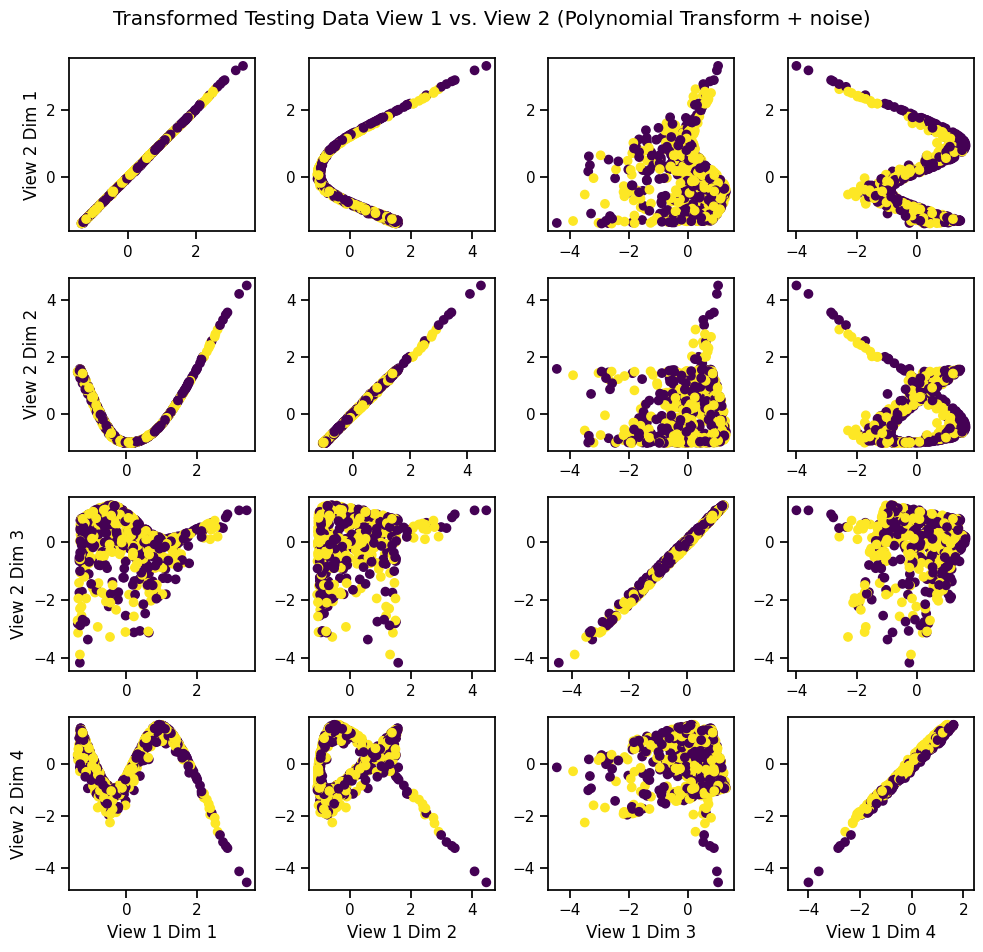

In [46]:
crossviews_plot(Xs_transformed, labels=y_test,
                title='Transformed Testing Data View 1 vs. View 2 '
                      '(Polynomial Transform + noise)',
                equal_axes=True)

## Sinusoidal-Transformed Latent Correlation

Following the same procedure as above, latent variables are sampled from two
multivariate Gaussians with equal prior probability. This time, a sinusoidal
transformation is applied and noise is added independently to both the
transformed and untransformed latents.



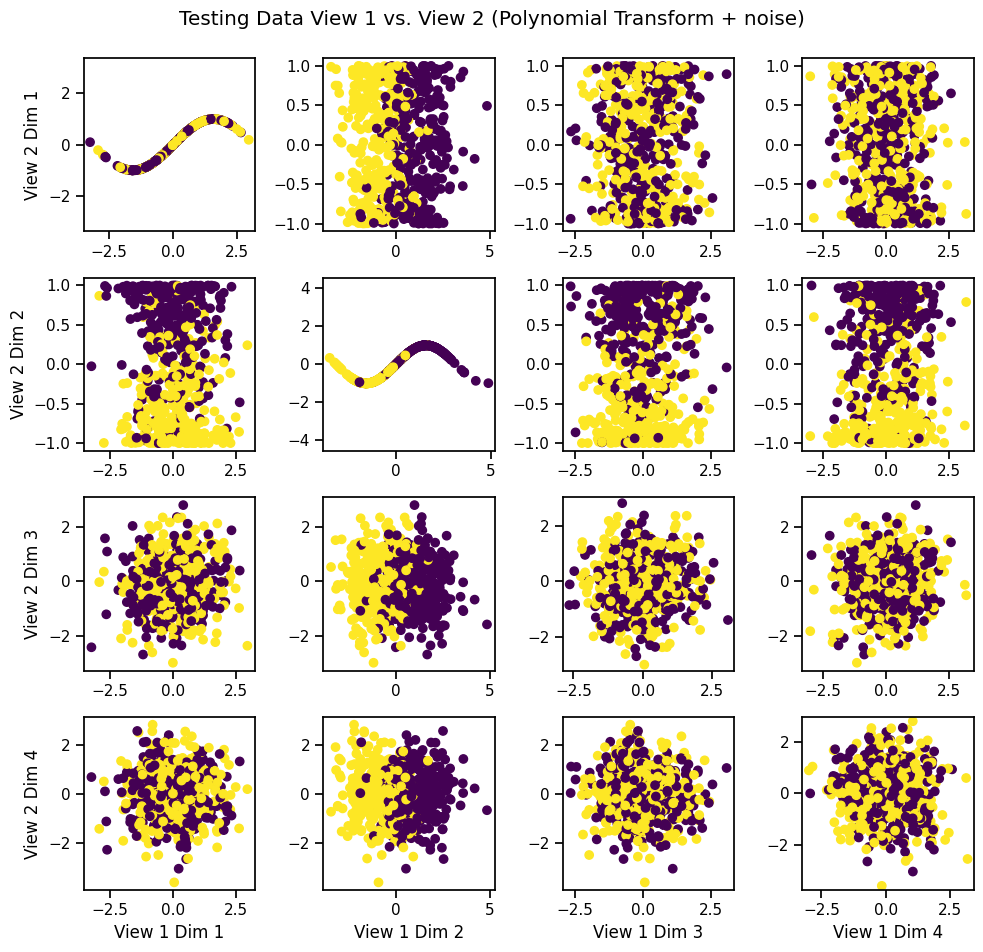

In [24]:
n_samples = 2000
means = [[0, 1], [0, -1]]
covariances = [np.eye(2), np.eye(2)]
Xs, y, latent = make_gaussian_mixture(
      n_samples, means, covariances, transform='sin', random_state=42,
      shuffle=True, shuffle_random_state=42, return_latents=True, noise_dims=2)

# Split data into train and test segments
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3,
                                                      random_state=42)

# Plot the testing data against itself after polynomial transformation
crossviews_plot(Xs_test, labels=y_test,
                title='Testing Data View 1 vs. View 2 '
                      '(Polynomial Transform + noise)',
                equal_axes=True)

## Fit DCCA Model to Uncover Latent Distribution

The output dimensionality is still 4.



In [26]:
# Define parameters and layers for deep model
features1 = Xs_train[0].shape[1]  # Feature sizes
features2 = Xs_train[1].shape[1]
layers1 = [256, 256, 4]  # nodes in each hidden layer and the output size
layers2 = [256, 256, 4]

dcca = DCCA(input_size1=features1, input_size2=features2, n_components=4,
            layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=500, device='cuda')
dcca.fit(Xs_train)
Xs_transformed = dcca.transform(Xs_test)

## Visualize the Transformed Data

We can see that it has uncovered the latent correlation between views.



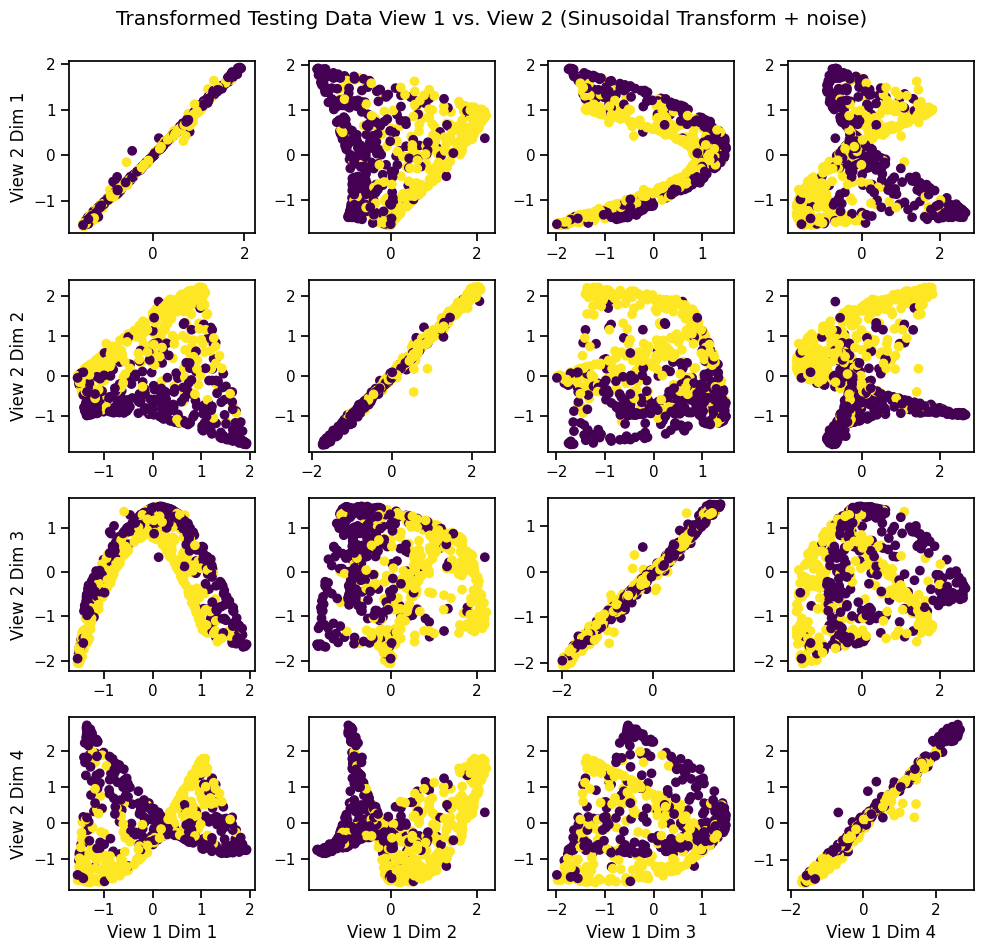

In [27]:
crossviews_plot(Xs_transformed, labels=y_test,
                title='Transformed Testing Data View 1 vs. View 2 '
                      '(Sinusoidal Transform + noise)',
                equal_axes=True)